In [0]:
##imports
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

Using TensorFlow backend.


In [0]:
##Loading the image files from the google drive
##importing google colab essentials:--
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
##Authentication

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 25.6MB/s 


In [0]:
file_id = "1xuAg3P1taDse4pC-KrwjtWhvZR8sOFTn"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('train.zip')

In [0]:
## Unzipping the datafile
!unzip train.zip

In [0]:
!ls

adc.json  sample_data  Train  train.csv  train.zip


In [0]:
##Initial data analysis
import pandas as pd
label = pd.read_csv("train.csv")
label.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

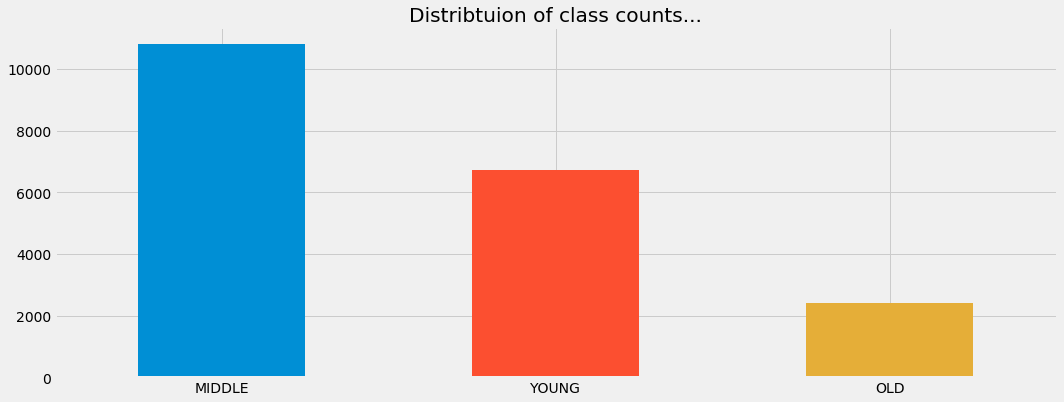

In [0]:
##inspecting the distribution of classes...
plt.figure(figsize = (16,6))
plt.style.use("fivethirtyeight")
label['Class'].value_counts(dropna = False).plot(kind = 'bar',grid = True)
plt.title("Distribtuion of class counts...")
plt.xticks(rotation = 0)

In [0]:
##Loading all the images in the memory...
from imageio import imread
from skimage.transform import resize
print("Libraries are loaded....")

temp = []
for img_name in label.ID:
    img_path = os.path.join('Train', img_name)
    img = imread(img_path)
    img = resize(img, (32, 32))
    img = img.astype('float32') # this will help us in later stage
    temp.append(img)

# stroring as a numpy array
data = np.stack(temp)

print("shape of loaded image data is {}:".format(data.shape))

Libraries are loaded....


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


shape of loaded image data is (19906, 32, 32, 3):


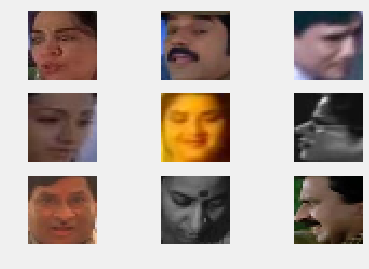

In [0]:
##Displaying the images...
fig,ax = plt.subplots(nrows = 3,ncols = 3,sharex = False,sharey = False)
for i in range(3):
    for j in range(3):
        img_id = np.random.randint(0,19000)
        ax[i][j].imshow(data[img_id])
        ax[i][j].set_axis_off()
plt.show()

# Model-1(VGG-16)

In [0]:
##necessary keras imports
from keras.models import Sequential,Model
from keras.layers import Flatten,Dense,Dropout,BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
from keras import applications

In [0]:
##Clearning the session
K.clear_session()

In [0]:
# Number of epochs
epochs = 30

# Batchsize
batch_size = 64

# Optimizer for the model
optimizer = Adam(lr=0.0001, beta_1=0.5)

# Shape of the input image
input_shape = (299, 299, 3)

# Batch interval at which loss is to be stores
store = 40 

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
##Loading the VGG16 model
from keras.applications.vgg16 import VGG16
model = VGG16(weights = "imagenet", include_top=False, input_shape = input_shape)
print("Model - VGG16  is loaded....")

Model - VGG16  is loaded....


In [0]:
##shaping the target variable..
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
target = enc.fit_transform(label['Class'])

In [0]:
##using np_utils to convert to keras input
from keras import utils
target = utils.to_categorical(target)
target

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0         
__________

In [0]:
# set layers as non trainable
for layer in model.layers[:-6]:
    layer.trainable = False

In [0]:
# Adding custom Layers
x = model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128,activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

predictions = Dense(3, activation="softmax")(x)

In [0]:
# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# print summary
model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizer,metrics = ['accuracy'])

In [0]:
import PIL
from PIL import Image
import os
import sys
def readf():   
    try:   
        input_dir  = 'Train'  #path to img source folder
        img_size   = 299  #The image size (128, 256,etc)
        output_imgs = [] #output directory
        tclass = [ d for d in label.ID ]
        counter = 0
        for x in tclass:  
            img = Image.open(os.path.join(input_dir+'/'+x))
            img = img.resize((int(img_size),int(img_size)),Image.ANTIALIAS)
            img = np.array(img)
            output_imgs.append(img)
            counter +=1
    except IsADirectoryError:
        pass
    return output_imgs
images = readf()

In [0]:
##converting images to array
images = np.array(images)
images.shape

(19906, 299, 299, 3)

In [0]:
##setting up train_test_split
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(images,target,test_size = 0.20,stratify = target,random_state = 42)

print("Shape X_train {}:".format(X_train.shape))
print("Shape X_train {}:".format(X_val.shape))
print("Shape X_train {}:".format(y_train.shape))
print("Shape X_train {}:".format(y_val.shape))

Shape X_train (15924, 299, 299, 3):
Shape X_train (3982, 299, 299, 3):
Shape X_train (15924, 3):
Shape X_train (3982, 3):


In [0]:
##preserving some space..
del images

In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
clr_triangular = CyclicLR(mode='triangular')

In [0]:
from keras.callbacks import ReduceLROnPlateau
lr_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 3,verbose = 1,factor = 0.2,min_lr = 0.00001)

In [0]:
history = model_final.fit(X_train,y_train,epochs = 5,batch_size = batch_size,validation_split = 0.09,callbacks = [lr_reduction,clr_triangular])
loss,acc = model_final.evaluate(X_val,y_val)

Train on 14490 samples, validate on 1434 samples
Epoch 1/5
14490/14490 [==============================] - 193s 13ms/step - loss: 0.8969 - acc: 0.6422 - val_loss: 7.8150 - val_acc: 0.4861
Epoch 2/5
14490/14490 [==============================] - 190s 13ms/step - loss: 0.5681 - acc: 0.7656 - val_loss: 10.4585 - val_acc: 0.3403
Epoch 3/5
14490/14490 [==============================] - 190s 13ms/step - loss: 0.4047 - acc: 0.8369 - val_loss: 7.9192 - val_acc: 0.4916
Epoch 4/5
14490/14490 [==============================] - 190s 13ms/step - loss: 0.2836 - acc: 0.8906 - val_loss: 9.5580 - val_acc: 0.3808
Epoch 5/5
3982/3982 [==============================] - 50s 13ms/step


In [0]:
print("The accuray of the model is {}".format(acc))
print("The loss achieved is {}".format(loss))

In [0]:
##Model training graph...
plt.style.use('fivethirtyeight')
def loss_plot(history):
    
    ##plotting accuracy
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    plt.figure(figsize = (16,6))
    plt.plot(np.arange(1,6),train_acc,marker = 'D',label = 'Training_Accuracy')
    plt.plot(np.arange(1,6),val_acc,marker = 'o',label = 'Validation Accuracy')
    plt.xlabel("EPOCHS")
    plt.ylabel("Accuracy")
    plt.title("Train/Validation Accuracy")
    plt.legend(loc = 'best')
    plt.margins(0.02)
    plt.show()
    
    
    ##plotting loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize = (16,6))
    plt.plot(np.arange(1,6),train_loss,marker = 'D',label = 'Training Loss')
    plt.plot(np.arange(1,6),val_loss,marker = 'o',label = 'Validation Loss')
    plt.xlabel("EPOCHS")
    plt.ylabel("Loss")
    plt.title("Train/Validation Loss")
    plt.legend(loc = 'best')
    plt.margins(0.02)
    plt.show()
    

In [0]:
##Getting the plots...
loss_plot(history)

In [0]:
from keras.preprocessing.image import ImageDataGenerator
    
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_datagen.fit(X_train)
validation_datagen.fit(X_val)

In [0]:
# Train the model
history = model_final.fit_generator(
      train_datagen,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=30,
      validation_data=validation_datagen,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)


In [0]:
##Save the model....
model_final.save("banchmark_vgg16.h5")

In [0]:
!ls

adc.json  banchmark_vgg16.h5  sample_data  Train  train.csv  train.zip


In [0]:
from google.colab import files
files.download('banchmark_vgg16.h5')